# Binary-Binary RBMs for feature representation
Assignment 2 **Task 4** | Notebook by **Group 19**

In this task, we will train three binary-binary RBMs to successively generate reduced dimension representations of the data, which will later be used for classification. The `RBM` class used in creating and training the RBMs below has been defined in `RBM_Builder.py`.  

In [1]:
# Dependencies
import os
import random
import numpy as np
import pandas as pd
from glob import glob
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
%matplotlib notebook

# RBM class from our custom defined script
from RBM_Builder import RBM
from RBM_Builder import DataLoader

# PyTorch 
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

## Loading data
In this section, the images and corresponding labels are loaded as numpy arrays (flattened to 1 dimension).

In [14]:
# Data collector

def generate_data(root_path):
    
    all_data, labels = [], []
    
    for f in tqdm(os.listdir(root_path)):
        data = pd.read_csv(root_path + '/' + f, header=None)
        all_data.extend(data.values)
        labels.extend([f]*len(data))
        
    all_data, labels = np.array(all_data), np.array(labels)
    
    # Label encode
    le = LabelEncoder()
    labels = le.fit_transform(labels)
    
    return all_data, labels


# Data loader generator

def get_data_loaders(features, target, batch_size=500, test_split=0.2):
    
    if test_split is not None:
        X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=test_split, shuffle=True)
        X_train, X_test = torch.from_numpy(X_train), torch.from_numpy(X_test)
        y_train, y_test = torch.from_numpy(y_train), torch.from_numpy(y_test)

        d_train = torch.utils.data.TensorDataset(X_train, y_train)
        d_test = torch.utils.data.TensorDataset(X_test, y_test)

        train_loader = torch.utils.data.DataLoader(d_train, batch_size=batch_size, shuffle=True)
        test_loader = torch.utils.data.DataLoader(d_test, batch_size=batch_size, shuffle=True)
        
        return train_loader, test_loader
    
    else:
        X, y = torch.from_numpy(features), torch.from_numpy(target)
        dataset = torch.utils.data.TensorDataset(X, y)
        loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
        
        return loader


# Process images

def process_images(data):
    
    """Not needed for the purpose of this task
       Reshapes images from (1, 784) --> (1, 28, 28)
       Don't know why I wrote this function"""
    
    images = []
    
    for i in data:
        images.extend(i.reshape(1, 28, 28))
        
    return np.asarray(images).reshape(-1, 1, 28, 28)


# Get data
all_data, labels = generate_data(root_path='../data/data2')

# Scale down image data to between 0 and 1
scaler = MinMaxScaler()
all_data = scaler.fit_transform(all_data)

## Runtime functions
Here we define functions for training and evaluation of the model's progress. First, we define functions for classifier networks with Nonlinear Logloss (NLL Loss). Functions required for training and evaluating RBM's learning progress have been defined in the RBM class itself. 

In [11]:
# Training function

def train_clf(model, train_loader, optimizer, epoch):
    # Set model in training mode
    model.train()  
    # List to store loss values for each batch
    loss_history = []
    correct = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        # Initialize optimizer
        optimizer.zero_grad()
        # Generate predictions using model
        output = model(data.float())
        # Compute loss (Nonlinear logloss)
        loss = F.nll_loss(output, target)
        # Append value of loss to loss_history list
        loss_history.append(loss.item())
        # Backpropagate loss to improve model parameters
        loss.backward()
        # Find number of correct predictions
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        # Update optimizer parameters
        optimizer.step()
    
    accuracy = 100*correct/len(train_loader.dataset)
    
    return np.array(loss_history).mean(), accuracy
        
    
# Test function

def test_clf(model, test_loader, epoch, log_freq=10):
    # Set model in evaluation mode
    # Model paramters do not change when in this state
    model.eval()
    # Counters for overall loss and correct classifications for test data
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            # Generate model predictions
            output = model(data.float())
            # Compute loss value (sum over all examples) and update test_loss 
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            # Find prediction index
            pred = output.argmax(dim=1, keepdim=True)
            # Transform target into one-hot vector and find number of correct classifications
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    # Average test loss over test data
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100.*correct/len(test_loader.dataset)
    
    # Console ouptut
    if epoch % log_freq == 0:
        print("Test {} : Average loss: {:.4f} \t Accuracy: {}/{} ({:.2f}%)".format(
            epoch, test_loss, correct, len(test_loader.dataset), test_accuracy
        ))
        
    return test_loss, test_accuracy 

## Defining and training RBMs
In this section, we will define three RBMs with the following input and output dimensions, train them, and obtain a reduced dimension representation of the data.

$$
(784, 500) \quad => \quad (500, 300) \quad => \quad (300, 200)
$$

In [30]:
BATCH_SIZE = 1000

# First RBM
d_loader_1 = DataLoader()
train_data_1 = d_loader_1.create_dataset(data=all_data, batch_size=BATCH_SIZE, shuffle=True)

rbm_1 = RBM(
    v_nodes = all_data.shape[1],
    h_nodes = 500,
    cd_steps = 1,
    visible_binary = True,
    batch_size = BATCH_SIZE,
    learning_rate = 0.001
)

energy_hist_1, rec_error_hist_1 = rbm_1.train(train_data_1, epochs=50, verbosity='shallow')
latent_1 = rbm_1.get_hidden(all_data)

In [31]:
# Second RBM
# Dataloader is initialized using latent_1 from rbm_1
d_loader_2 = DataLoader()
train_data_2 = d_loader_2.create_dataset(data=latent_1, batch_size=BATCH_SIZE, shuffle=True)

rbm_2 = RBM(
    v_nodes = 500,
    h_nodes = 300,
    cd_steps = 1,
    visible_binary = True,
    batch_size = BATCH_SIZE,
    learning_rate = 0.01
)

energy_hist_2, rec_error_hist_2 = rbm_2.train(train_data_2, epochs=50, verbosity='shallow')
latent_2 = rbm_2.get_hidden(latent_1)

In [32]:
# Third RBM
# Dataloader is initialized using latent_2 from rbm_2
d_loader_3 = DataLoader()
train_data_3 = d_loader_3.create_dataset(data=latent_2, batch_size=BATCH_SIZE, shuffle=True)

rbm_3 = RBM(
    v_nodes = 300,
    h_nodes = 200,
    cd_steps = 1,
    visible_binary = True,
    batch_size = BATCH_SIZE,
    learning_rate = 0.01
)

energy_hist_3, rec_error_hist_3 = rbm_3.train(train_data_3, epochs=50, verbosity='shallow')
latent_3 = rbm_3.get_hidden(latent_2)

## Classification using reduced features
We will now use `latent_3` as input to a classifier network and predict the class of every vector.

Test 0 : Average loss: 1.6101 	 Accuracy: 1189/6000 (19.82%)
Test 10 : Average loss: 1.6097 	 Accuracy: 1189/6000 (19.82%)
Test 20 : Average loss: 1.6095 	 Accuracy: 1189/6000 (19.82%)
Test 30 : Average loss: 1.6095 	 Accuracy: 1153/6000 (19.22%)
Test 40 : Average loss: 1.6096 	 Accuracy: 1153/6000 (19.22%)
Test 50 : Average loss: 1.6096 	 Accuracy: 1153/6000 (19.22%)
Test 60 : Average loss: 1.6096 	 Accuracy: 1153/6000 (19.22%)
Test 70 : Average loss: 1.6096 	 Accuracy: 1153/6000 (19.22%)
Test 80 : Average loss: 1.6096 	 Accuracy: 1153/6000 (19.22%)
Test 90 : Average loss: 1.6096 	 Accuracy: 1153/6000 (19.22%)


<IPython.core.display.Javascript object>


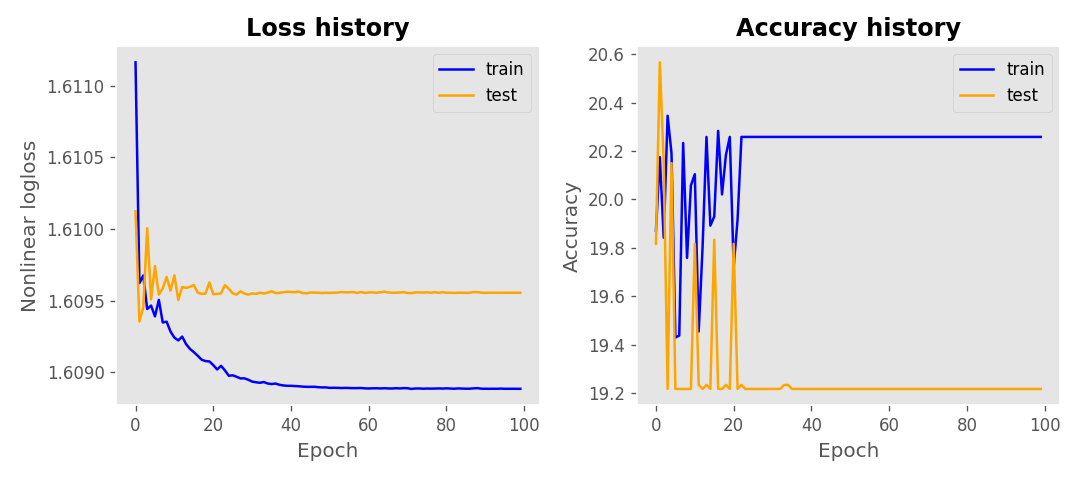

Final training loss: 1.6089
Final training accuracy: 20.2583
Final validation loss: 1.6096
Final validation accuracy: 19.2167


In [38]:
class Net(torch.nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.dense1 = torch.nn.Linear(200, 10)
        self.dense2 = torch.nn.Linear(10, 5)
        
    def forward(self, x):
        """Forward pass"""
        x = self.dense1(x)
        x = self.dense2(x)
        out = F.log_softmax(x, dim=1)
        return out
    

# Data loaders
# Generate data loaders for latent_3
train_loader, test_loader = get_data_loaders(latent_3, labels, test_split=0.2)

# Training 
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.005)
scheduler = StepLR(optimizer, step_size=1, gamma=0.9)

train_loss_hist, test_loss_hist = [], []
train_accuracy_hist, test_accuracy_hist = [], []

for epoch in range(100):
    train_loss, train_accuracy = train_clf(model, train_loader, optimizer, epoch)
    test_loss, test_accuracy = test_clf(model, test_loader, epoch, log_freq=10)
    scheduler.step()
    train_loss_hist.append(train_loss)
    train_accuracy_hist.append(train_accuracy)
    test_loss_hist.append(test_loss)
    test_accuracy_hist.append(test_accuracy)
    

# Plots of loss and accuracy
fig = plt.figure(figsize=(9, 4))

# Loss plots
ax1 = fig.add_subplot(121)
ax1.plot(train_loss_hist, color='blue', label='train')
ax1.plot(test_loss_hist, color='orange', label='test')
ax1.set_title('Loss history', fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Nonlinear logloss')
ax1.grid()
ax1.legend()

# Accuracy plots
ax2 = fig.add_subplot(122)
ax2.plot(train_accuracy_hist, color='blue', label='train')
ax2.plot(test_accuracy_hist, color='orange', label='test')
ax2.set_title('Accuracy history', fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.tight_layout()
plt.show()

# Final training and validation accuracy
print("Final training loss: {:.4f}".format(train_loss_hist[-1]))
print("Final training accuracy: {:.4f}".format(train_accuracy_hist[-1]))
print("Final validation loss: {:.4f}".format(test_loss_hist[-1]))
print("Final validation accuracy: {:.4f}".format(test_accuracy_hist[-1]))

## Model energy and reconstruction error trends
Let's have a look at the trends of state energies and reconstruction errors of each RBM. To calculate these, state energy and reconstruction error was average over all examples in every batch. The average of each quantities over all batches in an epoch is held as the value for that epoch.

<IPython.core.display.Javascript object>


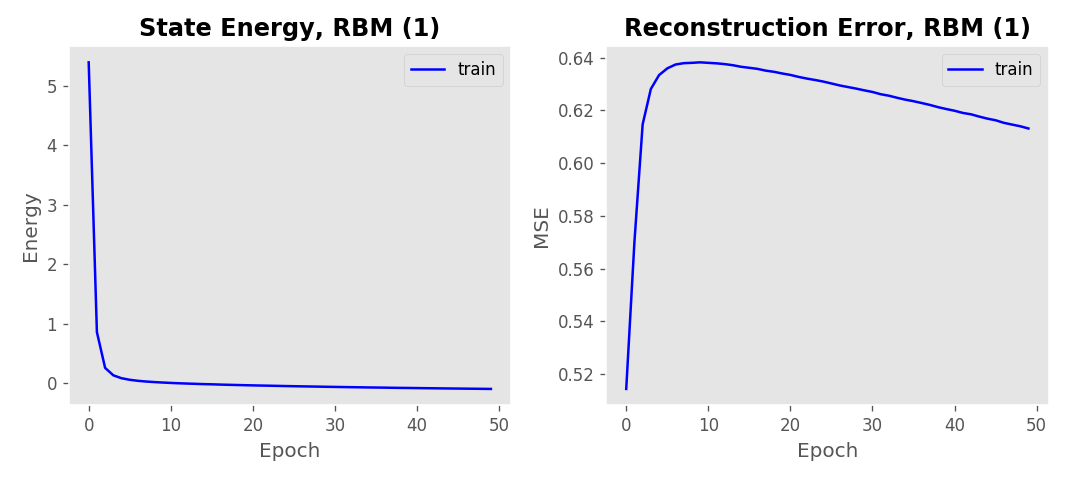

In [39]:
# For rbm_1

fig = plt.figure(figsize=(9, 4))

# Loss plots
ax1 = fig.add_subplot(121)
ax1.plot(energy_hist_1, color='blue', label='train')
ax1.set_title('State Energy, RBM (1)', fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Energy')
ax1.grid()
ax1.legend()

# Accuracy plots
ax2 = fig.add_subplot(122)
ax2.plot(rec_error_hist_1, color='blue', label='train')
ax2.set_title('Reconstruction Error, RBM (1)', fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('MSE')
ax2.grid()
ax2.legend()

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


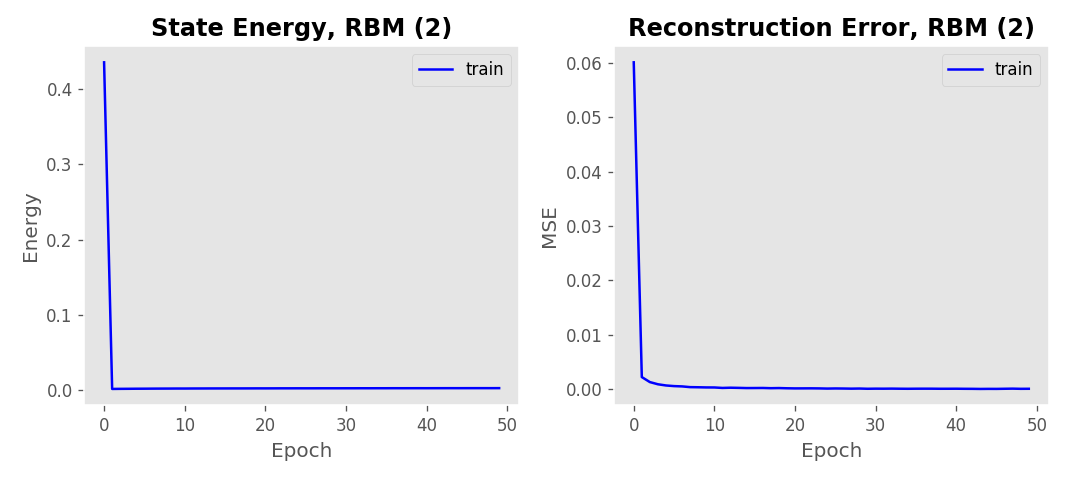

In [40]:
# For rbm_2

fig = plt.figure(figsize=(9, 4))

# Loss plots
ax1 = fig.add_subplot(121)
ax1.plot(energy_hist_2, color='blue', label='train')
ax1.set_title('State Energy, RBM (2)', fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Energy')
ax1.grid()
ax1.legend()

# Accuracy plots
ax2 = fig.add_subplot(122)
ax2.plot(rec_error_hist_2, color='blue', label='train')
ax2.set_title('Reconstruction Error, RBM (2)', fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('MSE')
ax2.grid()
ax2.legend()

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


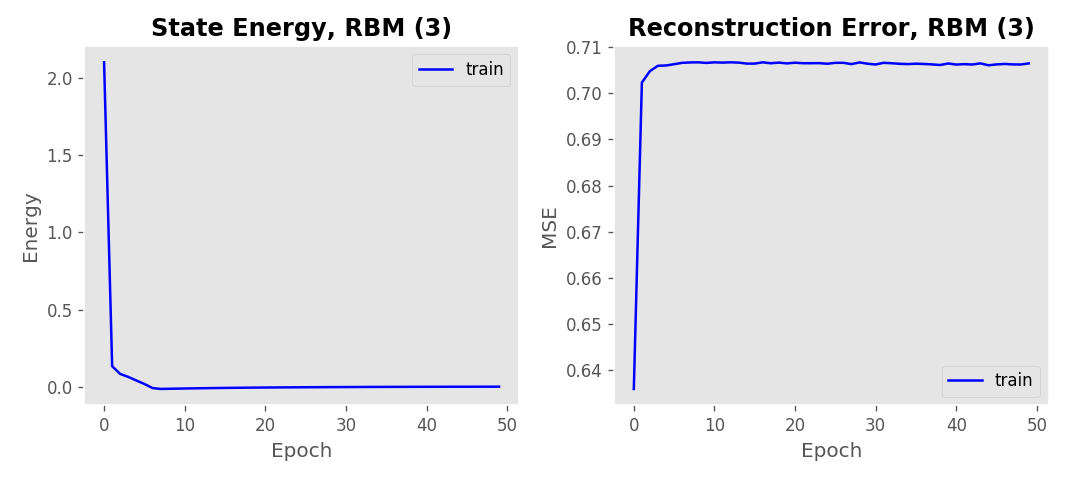

In [41]:
# For rbm_3

fig = plt.figure(figsize=(9, 4))

# Loss plots
ax1 = fig.add_subplot(121)
ax1.plot(energy_hist_3, color='blue', label='train')
ax1.set_title('State Energy, RBM (3)', fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Energy')
ax1.grid()
ax1.legend()

# Accuracy plots
ax2 = fig.add_subplot(122)
ax2.plot(rec_error_hist_3, color='blue', label='train')
ax2.set_title('Reconstruction Error, RBM (3)', fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('MSE')
ax2.grid()
ax2.legend()

plt.tight_layout()
plt.show()

## How good is the reconstruction?
Since the latent representation of our data is binary, let's render the output on a heatmap to see if any of the data's original variance has been retained in the latent representation. Considering the model performance and the plots above, we cannot expect anything good.

<IPython.core.display.Javascript object>


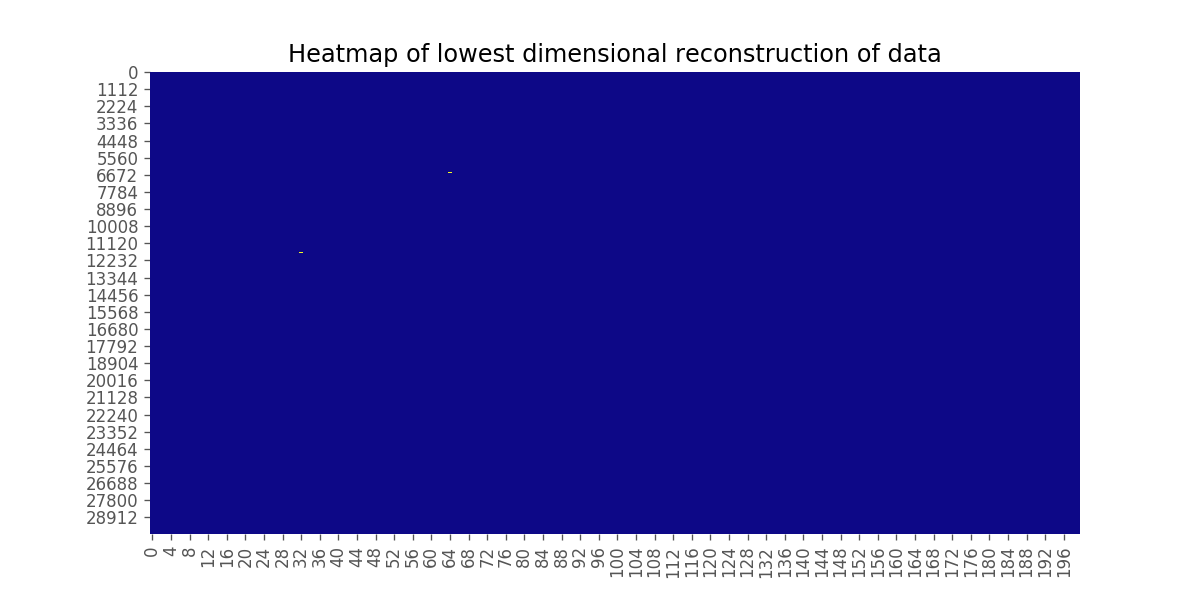

Text(0.5, 1, 'Heatmap of lowest dimensional reconstruction of data')

In [45]:
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.heatmap(latent_3, cbar=False, cmap='plasma')
plt.title('Heatmap of lowest dimensional reconstruction of data')

The data has converted into a pool of 0's with 1's what seems to be only 2 locations. It is obvious that the model cannot perform well on such representations.